# Final Project

## Teammates: Prakhar Saxena, Stephen Hansen, Tharindu Mendis

## Imports

In [3]:
import pandas as pd

import numpy as np
from numpy import dot as dot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import math
import copy

### Feature Column Splitting

In [4]:
def modify_data(df):
    for feature_split in feature_modifications:
        df = feature_split(df)
    x = df[feature_cols]
    full_cols = feature_cols[:]
    full_cols.append('Category')
    print(feature_cols)
    df_ = df[full_cols]
    y = output_col_mod(df)
    return x, y, df_

def date_time_split(df):
    def time_in_mins_since_midnight(time):
        return (time.hour * 60) + time.minute

    df['Time'] = pd.to_datetime(df['Dates']).dt.time.map(time_in_mins_since_midnight)

    def time_bin(hour):
        for bin_ in time_bins:
            if hour < bin_:
                return time_bins[bin_]

    df['Time_Class'] = pd.to_datetime(df['Dates']).dt.hour.map(time_bin)
    return df

def day_map(df):
    df = df.replace({"DayOfWeek": day_mapping})
    return df

def round_xy(df):
    if 'X' in feature_cols:
        df = df.round({'X': 2})
    if 'Y' in feature_cols:
        df = df.round({'Y': 2})
    return df

def drop_na(df):
    return df.dropna(subset=feature_cols)

# Modify Category to only include the top 5 most common crime categories 
# and everything else as other. Then assign values to each
def output_col_mod(df):
    df = df[['Category']]
    cols = output_col_mapping.keys()
    df = df.Category.map(output_col_mapping).fillna(output_col_mapping["OTHER OFFENSES"]).astype(int)
    df = df.to_frame().reset_index()
    df = df[['Category']]
    return df

### Defintions

In [5]:
dataset_dir = 'datasets/'

# Include any columns that might be produced as a result of any feature modification functions
# All columns will be numeric and this is being enforced
# X and Y will be automatically rounded if in feature_cols
# Drop_na should always be run last in feature modifications
feature_cols = ['Time', 'Time_Class', 'DayOfWeek', 'X', 'Y']
feature_modifications = [
    date_time_split,
    day_map,
    round_xy,
    drop_na
]


output_col = 'Category'

# How many different classifications to make?
output_col_mapping = {
    'LARCENY/THEFT': 0, 
    'NON-CRIMINAL': 1, 
    'ASSAULT': 2,
    'DRUG/NARCOTIC': 3,
    'VEHICLE THEFT': 4,
#     Includes other offenses and all offenses not included above
    'OTHER OFFENSES': 5,
}

# {'LARCENY/THEFT': 174900, 'OTHER OFFENSES': 126182, 'NON-CRIMINAL': 92304, 'ASSAULT': 76876, 
# 'DRUG/NARCOTIC': 53971, 'VEHICLE THEFT': 53781, 'VANDALISM': 44725, 'WARRANTS': 42214, 
# 'BURGLARY': 36755, 'SUSPICIOUS OCC': 31414, 'MISSING PERSON': 25989, 'ROBBERY': 23000, 
# 'FRAUD': 16679, 'FORGERY/COUNTERFEITING': 10609, 'SECONDARY CODES': 9985, 'WEAPON LAWS': 8555, 
# 'PROSTITUTION': 7484, 'TRESPASS': 7326, 'STOLEN PROPERTY': 4540, 'SEX OFFENSES FORCIBLE': 4388, 
# 'DISORDERLY CONDUCT': 4320, 'DRUNKENNESS': 4280, 'RECOVERED VEHICLE': 3138, 'KIDNAPPING': 2341, 
# 'DRIVING UNDER THE INFLUENCE': 2268, 'RUNAWAY': 1946, 'LIQUOR LAWS': 1903, 'ARSON': 1513, 
# 'LOITERING': 1225, 'EMBEZZLEMENT': 1166, 'SUICIDE': 508, 'FAMILY OFFENSES': 491, 'BAD CHECKS': 406, 
# 'BRIBERY': 289, 'EXTORTION': 256, 'SEX OFFENSES NON FORCIBLE': 148, 'GAMBLING': 146, 
# 'PORNOGRAPHY/OBSCENE MAT': 22, 'TREA': 6}


# Keys are evaluated as: hour is less than key
# Cycle runs from midnight 00:00 to 23:59
time_bins = {
    4: 0, # Before 4am is 0
    6: 1, # Before 6am is 1
    12: 2, # Before 12pm is 2
    18: 3, # Before 4pm is 3
    24: 4, # Before midnight is 4
}

day_mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
}

## General Functions

In [6]:
def test_train_split(x, y, shuffle=True, test_size=0.2):
    return train_test_split(x, y, test_size=test_size, random_state=0, shuffle=shuffle)

# Standardize by subtracting column mean and divide by the standard deviation of the column
def standardize_data(training_data, testing_data=None):
    scaler = StandardScaler()
    scaler.fit(training_data.to_numpy())
    training_data = scaler.transform(training_data.to_numpy())
    testing_data = scaler.transform(testing_data.to_numpy())
    
    return training_data, testing_data

# Prepare and Get test train data
def get_data():
    # Fixing random state for reproducibility
    np.random.seed(0)

    train = pd.read_csv(dataset_dir + 'train.csv')

    x, y, df = modify_data(train)

    X_train, X_test, y_train, y_test = test_train_split(x, y)

    # Standardize training and testing data using training
    # (Feature columns only)
    X_train, X_test = standardize_data(X_train, X_test)

    # Fixing random state for reproducibility again cause optional preparation steps
    # might have random steps
    np.random.seed(0)

    return X_train, X_test, y_train.to_numpy(), y_test.to_numpy(), df

# Decision Trees

In [14]:
X_train, X_test, y_train, y_test, df = get_data()
# df is pandas dataframe before standardizing data
# y_test and X_test are Category data and style can be found above
# X_train and y_train cols are feature cols in the order
# Currently Feature Cols are: ['Time', 'Time_Class', 'DayOfWeek', 'X', 'Y']
def get_entropy(y_values):
    h, w = y_values.shape
    unique, counts = np.unique(y_values, return_counts=True)
    entropy = 0
    for count in counts:
        P = count/h
        entropy += -P*np.log2(P)
    return entropy

def get_information_gains(X_values, y_values):
    h, w = X_values.shape
    gains = []
    for x in range(w): # x being our current feature
        col = X_values[:,x]
        unique, counts = np.unique(col, return_counts=True)
        totals = dict(zip(unique, counts))
        entropy = 0
        for t in totals:
            count = totals[t]
            P = count/h
            mask = col == t
            y_masked = y_values[mask]
            entropy += P*get_entropy(y_masked)
        gain = get_entropy(y_values) - entropy
        gains.append((x, gain))
        
    return sorted(gains, key=lambda x : x[1], reverse=True)

def group_dataset_by(X_values, y_values, index):
    h, w = X_values.shape
    col = X_values[:,index]
    unique, counts = np.unique(col, return_counts=True)
    X_filtered = np.delete(X_values, index, axis=1)
    groupings = []
    for u in unique: # loop over all unique groups
        mask = col == u
        X_masked = X_filtered[mask]
        y_masked = y_values[mask]
        groupings.append((X_masked, y_masked))
    return groupings, unique

class TreeNode:
    def __init__(self, label):
        self.label = label
        self.connections = []
        
    def addTree(self, edge_value, tree):
        self.connections.append((edge_value, tree))
        
    def __str__(self, level=0):
        ret = "\t"*level+repr(self.label)+"\n"
        for connection in self.connections:
            if connection[1] is not None:
                ret += connection[1].__str__(level+1)
        return ret
    
def build_tree_recurse(X, y, cols):
    if len(cols) == 1:
        unique, counts = np.unique(y, return_counts=True)
        i = np.argmax(counts)
        return TreeNode(unique[i])
    entropy = get_entropy(y)
    #print(f"The entropy is {entropy}")
    gains = get_information_gains(X, y)
    #print(f"The information gains of the training set are {gains}")
    best_feature = gains[0][0]
    #print(f"The best feature is {cols[best_feature]}")
    tree = TreeNode(cols[best_feature])
    columns = cols[:]
    columns.pop(best_feature)
    new_groups, unique = group_dataset_by(X, y, best_feature)
    for i in range(len(new_groups)):
        g = new_groups[i]
        u = unique[i]
        child_tree = build_tree_recurse(g[0], g[1], columns)
        tree.addTree(u, child_tree)
    return tree

def predict_DT(X, y, labels, tree):
    h, w = X.shape
    num_right = 0
    y_pred_arr = np.copy(y)
    for i in range(h):
        X_row = X[i,:]
        y_val = y[i,0]
        curr_node = tree
        while len(curr_node.connections) > 0:
            index = labels.index(curr_node.label)
            val = X_row[index]
            for c in curr_node.connections:
                edge = c[0]
                new_node = c[1]
                if edge == X_row[index]:
                    break
            curr_node = new_node
        y_pred = curr_node.label
        y_pred_arr[i,0] = y_pred
        if y_val == y_pred:
            num_right += 1
    return num_right / h, y_pred_arr

['Time', 'Time_Class', 'DayOfWeek', 'X', 'Y']


In [16]:
labels = ['Time', 'Time_Class', 'DayOfWeek', 'X', 'Y']
dtree = build_tree_recurse(X_train, y_train, labels)

In [17]:
accuracy_train, y_pred_train = predict_DT(X_train, y_train, labels, dtree)
print(f"Training accuracy = {accuracy_train}")
accuracy_test, y_pred_test = predict_DT(X_test, y_test, labels, dtree)
print(f"Testing accuracy = {accuracy_test}")

Training accuracy = 0.6252457508765886
Testing accuracy = 0.4163487272934343


In [10]:
print(dtree.connections[1][1])

'X'
	'Time_Class'
		'DayOfWeek'
			3
	'DayOfWeek'
		'Time_Class'
			5
		'Time_Class'
			0
	'Time_Class'
		'DayOfWeek'
			5
	'Time_Class'
		'DayOfWeek'
			4
	'Y'
		'Time_Class'
			5
		'Time_Class'
			5
		'Time_Class'
			4
		'Time_Class'
			5
		'Time_Class'
			5
	'DayOfWeek'
		'Time_Class'
			1
		'Time_Class'
			3
		'Time_Class'
			5
	'DayOfWeek'
		'Time_Class'
			2
		'Time_Class'
			2
		'Time_Class'
			5
		'Time_Class'
			5
	'DayOfWeek'
		'Time_Class'
			4
		'Y'
			1
			5
		'Y'
			3
			5
			5
		'Y'
			2
			5
		'Time_Class'
			1
		'Time_Class'
			5
		'Time_Class'
			5
	'Y'
		'Time_Class'
			5
		'Time_Class'
			5
		'Time_Class'
			5
		'Time_Class'
			5
		'Time_Class'
			5
		'DayOfWeek'
			4
			1
		'DayOfWeek'
			5
			2
			5
		'DayOfWeek'
			0
			5
			5
		'DayOfWeek'
			5
			0
	'Y'
		'DayOfWeek'
			5
			3
		'Time_Class'
			1
		'DayOfWeek'
			5
			5
		'Time_Class'
			4
		'DayOfWeek'
			5
			5
			3
			5
			1
		'DayOfWeek'
			5
			3
			5
			5
			3
			0
		'DayOfWeek'
			5
			5
			0
			5
			2
	

In [11]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_train_sk = clf.predict(X_train)
y_pred_test_sk = clf.predict(X_test)

In [12]:
num_right = 0
for i in range(y_train.shape[0]):
    if y_train[i,:] == y_pred_train_sk[i]:
        num_right += 1
sklearn_accuracy = num_right / y_train.shape[0]
print(f"Sklearn testing accuracy = {sklearn_accuracy}")
num_right = 0
for i in range(y_test.shape[0]):
    if y_test[i,:] == y_pred_test_sk[i]:
        num_right += 1
sklearn_accuracy = num_right / y_test.shape[0]
print(f"Sklearn testing accuracy = {sklearn_accuracy}")

Sklearn testing accuracy = 0.6252457508765886
Sklearn testing accuracy = 0.41511303456522974


In [26]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings
# Let's binarize the classes
labels = [0, 1, 2, 3, 4, 5]
from sklearn.preprocessing import label_binarize
y_pred_train_b = label_binarize(y_pred_train, classes=labels)
y_train_b = label_binarize(y_train, classes=labels)
y_pred_test_b = label_binarize(y_pred_test, classes=labels)
y_test_b = label_binarize(y_test, classes=labels)
n_classes = y_pred_train_b.shape[1]

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_train_b[:, i],
                                                        y_pred_train_b[:, i])
    average_precision[i] = average_precision_score(y_train_b[:, i], y_pred_train_b[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_train_b.ravel(),
    y_pred_train_b.ravel())
average_precision["micro"] = average_precision_score(y_train_b, y_pred_train_b,
                                                     average="micro")
print('Average training precision score, micro-averaged over all classes (training): {0:0.2f}'
      .format(average_precision["micro"]))

Average training precision score, micro-averaged over all classes (training): 0.45


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes (training): AP=0.45')

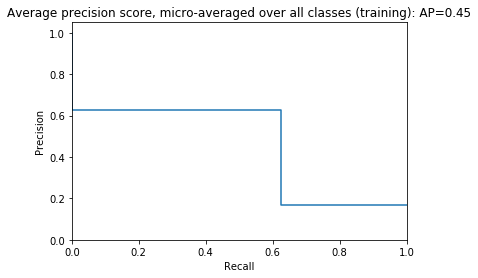

In [24]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes (training): AP={0:0.2f}'
    .format(average_precision["micro"]))

In [33]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
F1 = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_b[:, i],
                                                        y_pred_test_b[:, i])
    average_precision[i] = average_precision_score(y_test_b[:, i], y_pred_test_b[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_b.ravel(),
    y_pred_test_b.ravel())
average_precision["micro"] = average_precision_score(y_test_b, y_pred_test_b,
                                                     average="micro")
print('Average training precision score, micro-averaged over all classes (training): {0:0.2f}'
      .format(average_precision["micro"]))

Average training precision score, micro-averaged over all classes (training): 0.27


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes (training): AP=0.27')

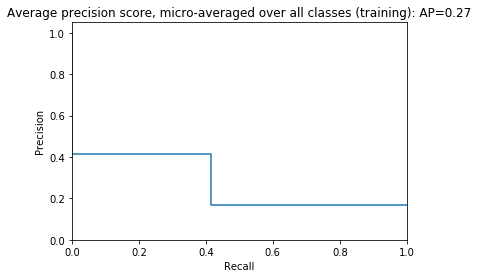

In [30]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes (training): AP={0:0.2f}'
    .format(average_precision["micro"]))